In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Exploration
I explore the *Credit Card Fraud Detection* dataset from Kaggle [source](https://www.kaggle.com/mlg-ulb/creditcardfraud).

This dataset contains data about transactions over a two day period in September 2013 by European credit-card holders, along with a label indicating whether the transaction was fraudulant, or not. Most of the details have already been transformed using PCA due to privacy.

**Table of Contents**
 * [Overview](#Overview)
 * [Time](#Time)
   * [Time and Fraud](#Time-and-Fraud)
 * [Amount](#Amount)
   * [Amount and Fraud](#Amount-and-Fraud)


In [3]:
# load data
data=pd.read_csv("data/creditcard.csv")

In [20]:
# split data
fraud_data=data[data["Class"]==1].copy()
not_fraud_data=data[data["Class"]==0].copy()
print("{:,} ({:.2f}%) fraudulent transactions.".format(fraud_data.shape[0],100*(fraud_data.shape[0]/data.shape[0])))
print("{:,} ({:.2f}%) not fraudulent transactions.".format(not_fraud_data.shape[0],100*(not_fraud_data.shape[0]/data.shape[0])))

492 (0.17%) fraudulent transactions.
284,315 (99.83%) not fraudulent transactions.


The vast marjority of transactions are not fraudulent. The imbalance in this dataset will need to be considered and address when producing our model.

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There are 284,807 transactions in the data set.
 * `Time` - Seconds between transaction and the first transaction in the database.
 * `V1`,...,`V28` - The 28 components produced by PCA.
 * `Amount` - The value of the transaction (In Euros?)
 * `Class` - Whether the transaction was fraudulent or not (1=fraud,0=not fraud)

## Time
**Note** - I am assuming that the first transaction occurred at (or near enough to) midnight of the first day. Further, we do not know which days of the week this data refers to, which could be an informative piece of data for detecting fraud.

In [7]:
print("min={:,.0f}s\nmax={:,.0f}s\n   ={:,.2f}d".format(data["Time"].min(),data["Time"].max(),data["Time"].max()/3600))

min=0s
max=172,792s
   =48.00d


The dataset covers a span of two days.

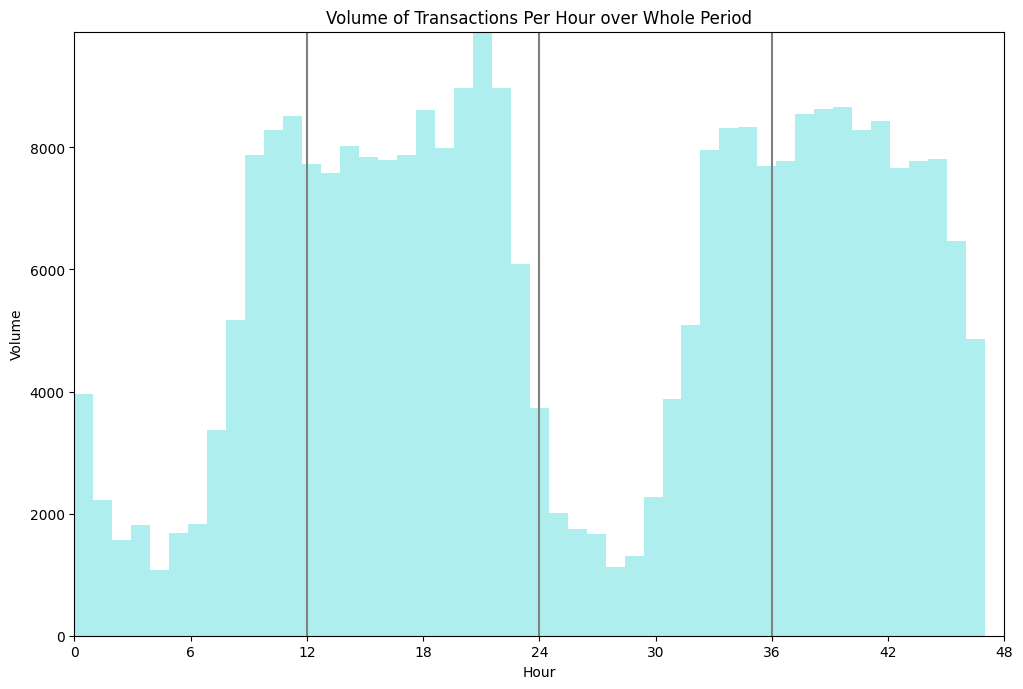

In [8]:
# Plot transaction in each hour slot over whole period
data["Hour"]=data["Time"]//3600
fraud_data["Hour"]=fraud_data["Time"]//3600
not_fraud_data["Hour"]=not_fraud_data["Time"]//3600

plt.hist(data["Hour"],bins=48,color="paleturquoise")

plt.title("Volume of Transactions Per Hour over Whole Period")
plt.xlabel("Hour")
plt.xticks([x for x in range(0,49,6)])
plt.ylabel("Volume")
for x in range(12,48,12): plt.axvline(x,c="gray")
    
plt.show()

There are obvious cycles in the volume of transactions, as is to be expected. The vast majority of transactions occur in the afternoon and with the volume of transactions being very consistent between 9am and 10pm.

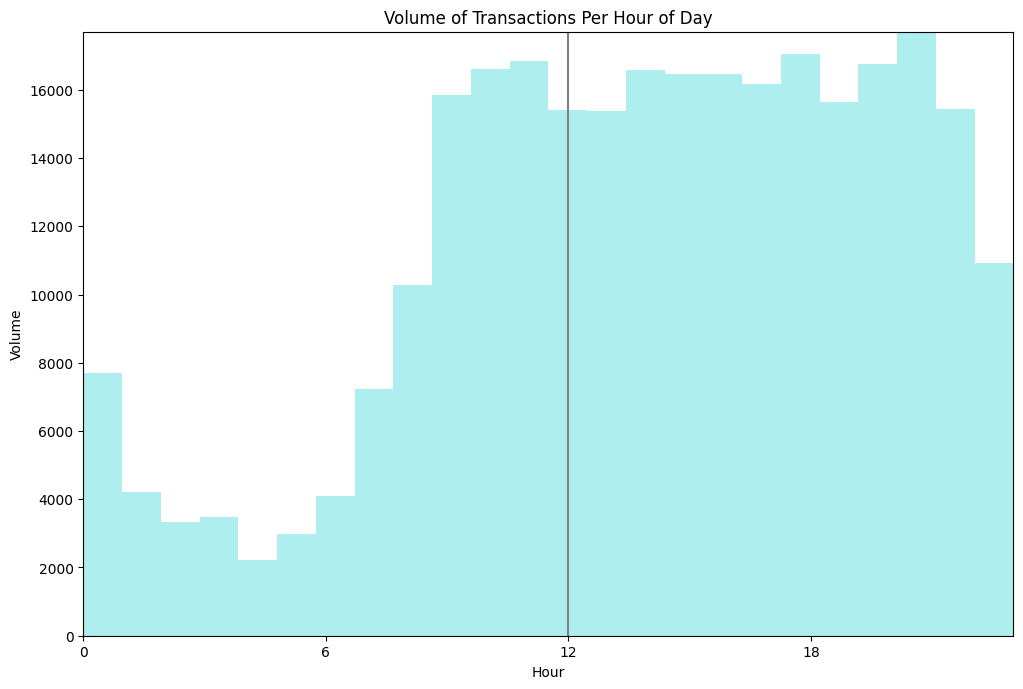

In [10]:
# Plot volume of transaction per hour of the day
data["Hour_of_Day"]=data["Hour"]%24
fraud_data["Hour_of_Day"]=fraud_data["Hour"]%24
not_fraud_data["Hour_of_Day"]=not_fraud_data["Hour"]%24

plt.hist(data["Hour_of_Day"],bins=24,color="paleturquoise")

plt.title("Volume of Transactions Per Hour of Day")
plt.xlabel("Hour")
plt.xticks([x for x in range(0,24,6)])
plt.ylabel("Volume")
for x in range(12,24,12): plt.axvline(x,c="gray") # Grid line to show midday
    
plt.show()

## Time and Fraud

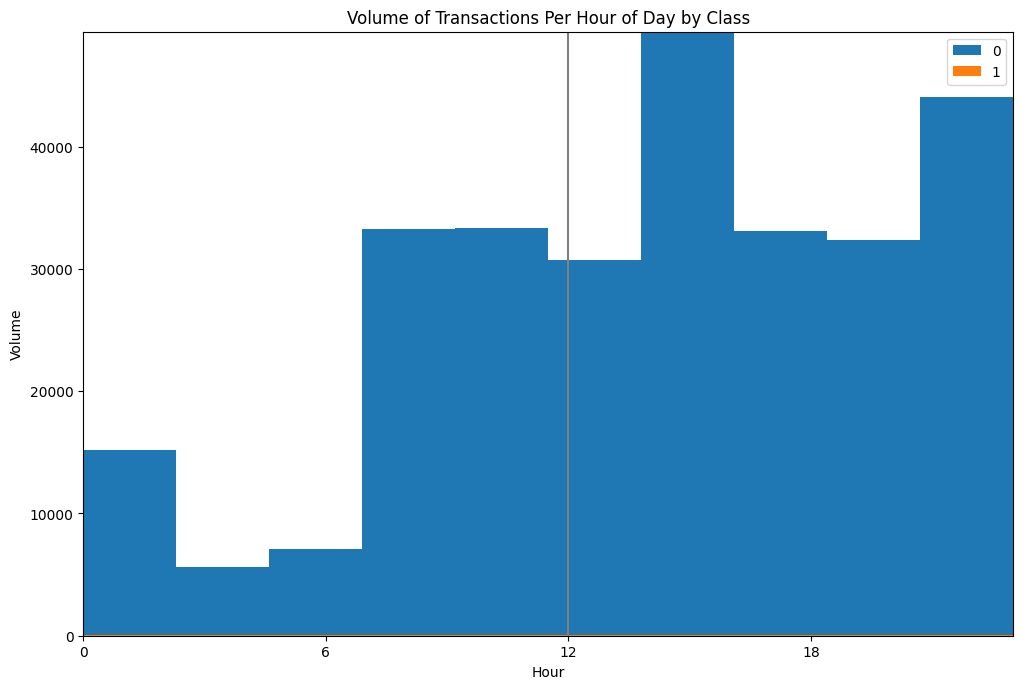

In [11]:
data.groupby("Class")["Hour_of_Day"].plot(kind='hist',stacked=True,legend=True)

plt.title("Volume of Transactions Per Hour of Day by Class")
plt.xlabel("Hour")
plt.xticks([x for x in range(0,24,6)])
plt.ylabel("Volume")
for x in range(12,24,12): plt.axvline(x,c="gray") # Grid line to show midday
    
plt.show()

This plot doesn't provide any extra information due to such a small proportion of the transactions in the dataset being fraudulent.

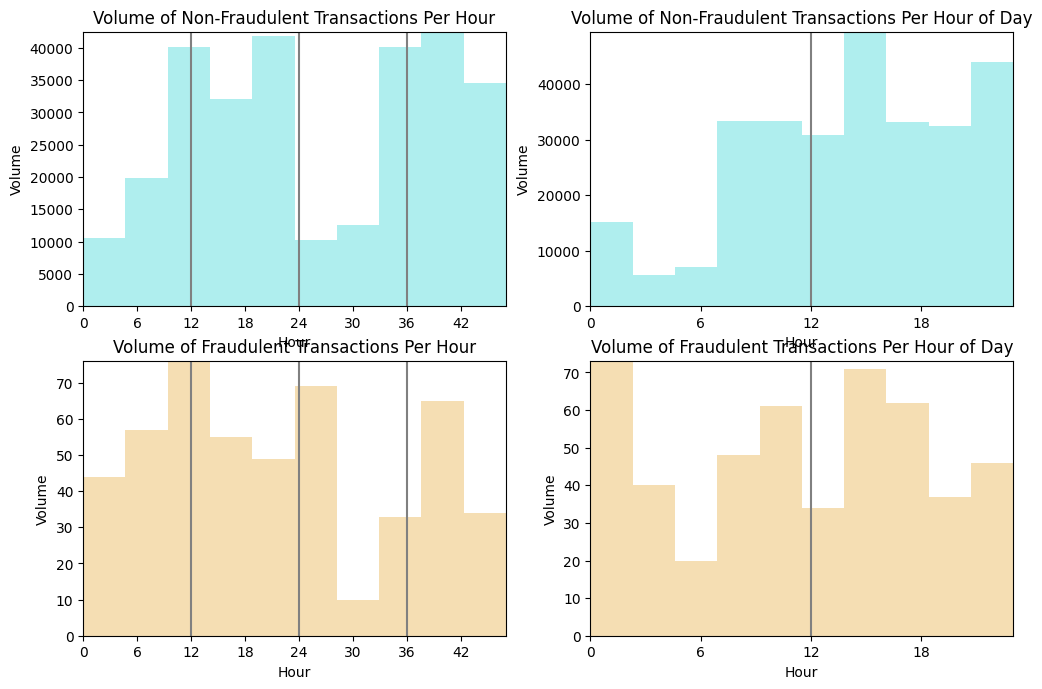

In [28]:
fig,ax=plt.subplots(nrows=2,ncols=2)

ax[0][0].hist(not_fraud_data["Hour"],color="paleturquoise")
ax[0][0].set_title("Volume of Non-Fraudulent Transactions Per Hour")

ax[1][0].hist(fraud_data["Hour"],color="wheat")
ax[1][0].set_title("Volume of Fraudulent Transactions Per Hour")

ax[0][1].hist(not_fraud_data["Hour_of_Day"],color="paleturquoise")
ax[0][1].set_title("Volume of Non-Fraudulent Transactions Per Hour of Day")

ax[1][1].hist(fraud_data["Hour_of_Day"],color="wheat")
ax[1][1].set_title("Volume of Fraudulent Transactions Per Hour of Day")

for i in range(0,2):
    ax[i][0].set_xlabel("Hour")
    ax[i][0].set_xticks([x for x in range(0,48,6)])
    ax[i][0].set_ylabel("Volume")
    for x in range(12,48,12): ax[i][0].axvline(x,c="gray") # Grid line to show midday
    
    ax[i][1].set_xlabel("Hour")
    ax[i][1].set_xticks([x for x in range(0,24,6)])
    ax[i][1].set_ylabel("Volume")
    for x in range(12,24,12): ax[i][1].axvline(x,c="gray") # Grid line to show midday

plt.show()

The daily trends which are evident in the non-fraudulent transactions is not evident in the fraudlent transactions. This could be due to the small sample of fraudulent transactions.

The distribution of fraudulent transactions appears much more uniform throughout the day and there is a notable peak around midnight which does not occur in the non-fraud data. This peak intuitevly feels worthy of further investigation.

# Amount

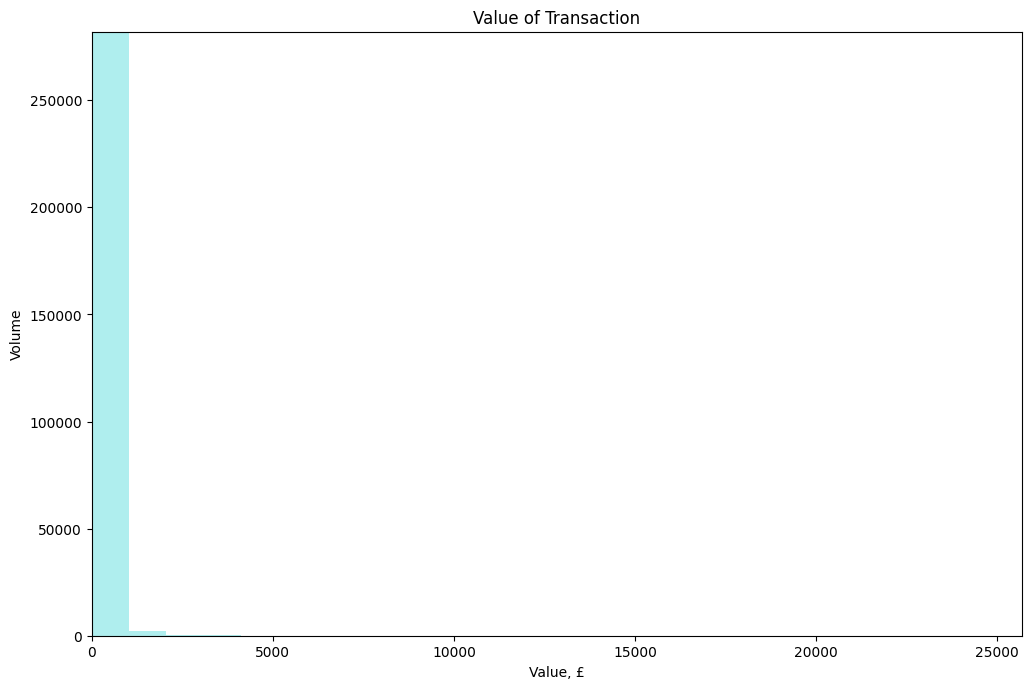

In [33]:
# Plot transaction in each hour slot over whole period
plt.hist(data["Amount"],bins=25,color="paleturquoise")

plt.title("Value of Transaction")
plt.xlabel("Value, £")
plt.ylabel("Volume")
    
plt.show()

Clearly the majority of transactions are low. Below I plot the distribution of transactions with value <£1,000.

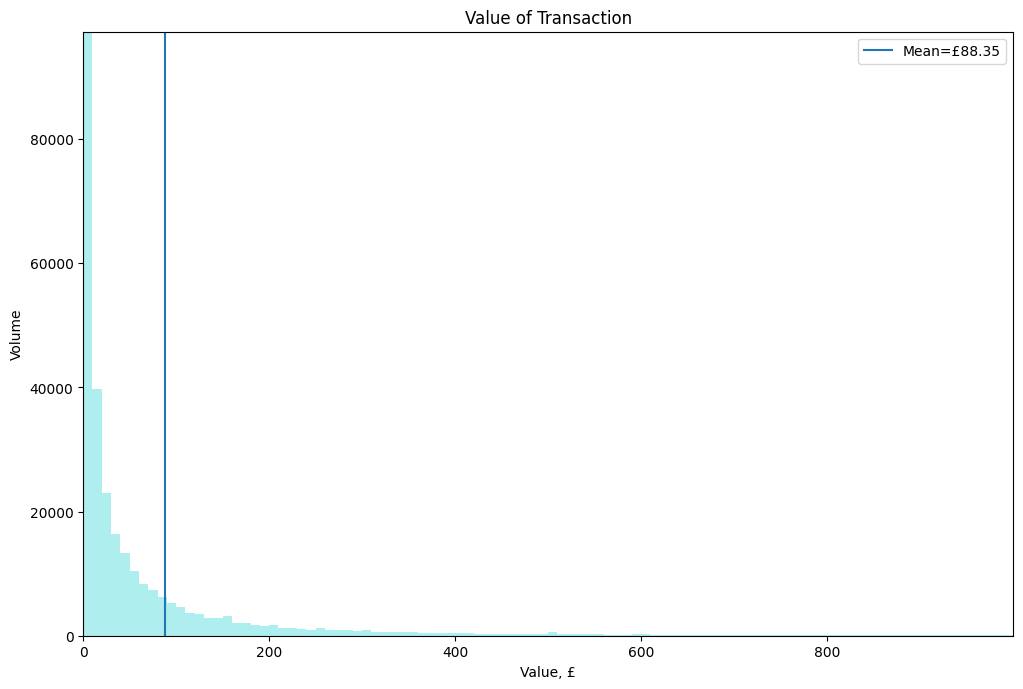

In [38]:
# Plot transaction in each hour slot over whole period
plt.hist(data[data["Amount"]<1000]["Amount"],bins=100,color="paleturquoise")

plt.title("Value of Transaction")
plt.xlabel("Value, £")
plt.ylabel("Volume")

plt.axvline(data["Amount"].mean(),label="Mean=£{:.2f}".format(data["Amount"].mean()))
plt.legend()

plt.show()

# Amount and Fraud